# Market analysis outdoor companies

The goal of this analysis is to compare the market position and product pricing for outdoor companies, especially on the european market. In step one revenues of major outdoor companies in the years from 2012-2020 are analysed to get an indication for market shares and growth rates. In step two product descriptions and prices for hiking clothes are scraped from the websites of two companies (Quechua + Vaude) and their pricing is investigated.

## 1. Market shares & growth

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import requests
from bs4 import BeautifulSoup
import re
from re import search
import seaborn as sns

1.1 Import and prepare data for analysis

In [2]:
df = pd.read_csv('outdoor.csv',sep=';',index_col=0)

In [3]:
df

,JackWolfskin,Mammut,Vaude,NorthFace,Columbia,Salewa,Decathlon
2012,351,NaN,75,4860,1670,160,7000
2013,324,247.0,80,5101,1685,180,7400
2014,345,250.0,82,5307,2101,202,8200
2015,314,235.0,84,4912,2326,205,9100
2016,351,233.0,91,4925,2377,205,10100
2017,331,229.0,97,3750,2466,210,11100
2018,334,253.0,102,1039,2802,210,11300
2019,319,268.0,102,4586,3042,230,12400
2020,309,218.0,110,4685,2501,240,11400


In [4]:
df.Mammut.fillna(df.Mammut.median(),inplace=True)
df['Mammut'] = df.Mammut.astype('int64')

In [5]:
employees_quechua = 200
employees_simond = 19
employees_decathlon = 93710

perc_retail = 0.759
perc_logistics = 0.131
perc_prod = 0.053
perc_support = 0.057

df['Quechua_Simond'] = df.Decathlon*((employees_quechua+employees_simond)/(employees_decathlon*(1-perc_retail)))
df['Quechua_Simond'] = df.Quechua_Simond.astype('int64')
df.drop(['Decathlon'],axis=1,inplace=True)

In [6]:
df

,JackWolfskin,Mammut,Vaude,NorthFace,Columbia,Salewa,Quechua_Simond
2012,351,241,75,4860,1670,160,67
2013,324,247,80,5101,1685,180,71
2014,345,250,82,5307,2101,202,79
2015,314,235,84,4912,2326,205,88
2016,351,233,91,4925,2377,205,97
2017,331,229,97,3750,2466,210,107
2018,334,253,102,1039,2802,210,109
2019,319,268,102,4586,3042,230,120
2020,309,218,110,4685,2501,240,110


1.2. Plot graphs to determine market shares and growth rates

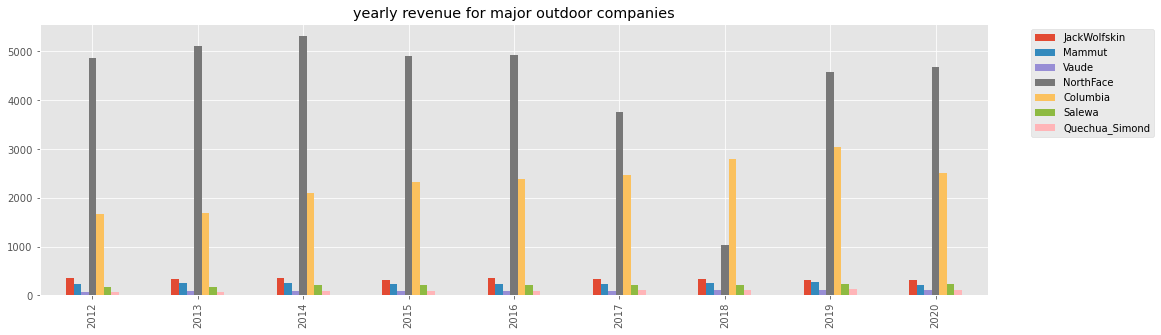

In [7]:
df.plot(kind='bar',figsize=(17,5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('yearly revenue for major outdoor companies');

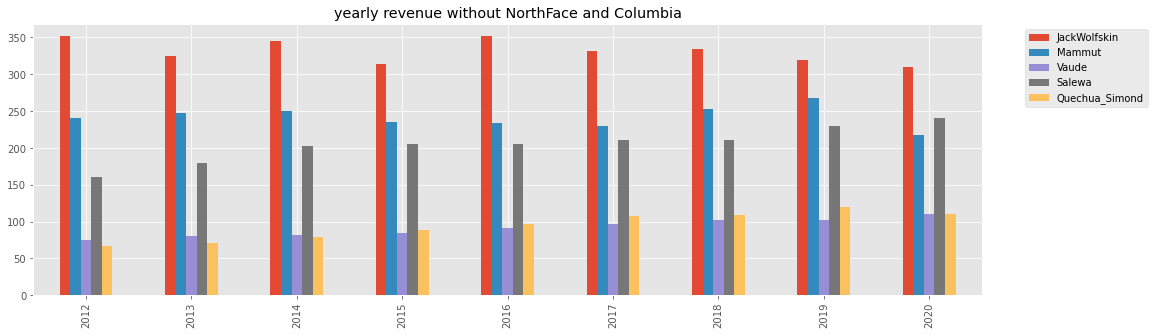

In [8]:
df.iloc[:,[0,1,2,5,6]].plot(kind='bar',figsize=(17,5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('yearly revenue without NorthFace and Columbia');

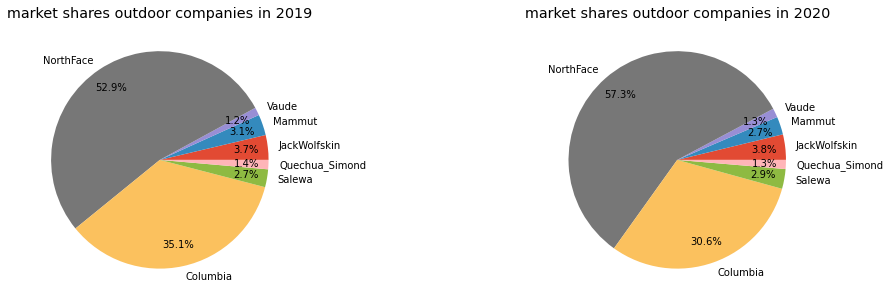

In [9]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(17,5))
labels = df.columns.tolist()
ax1.pie(x=df[df.index==2019].values.flatten().tolist(),labels=labels,autopct='%.1f%%',pctdistance=0.8)
ax2.pie(x=df[df.index==2020].values.flatten().tolist(),labels=labels,autopct='%.1f%%',pctdistance=0.8)
ax1.set_title('market shares outdoor companies in 2019')
ax2.set_title('market shares outdoor companies in 2020')
plt.show()

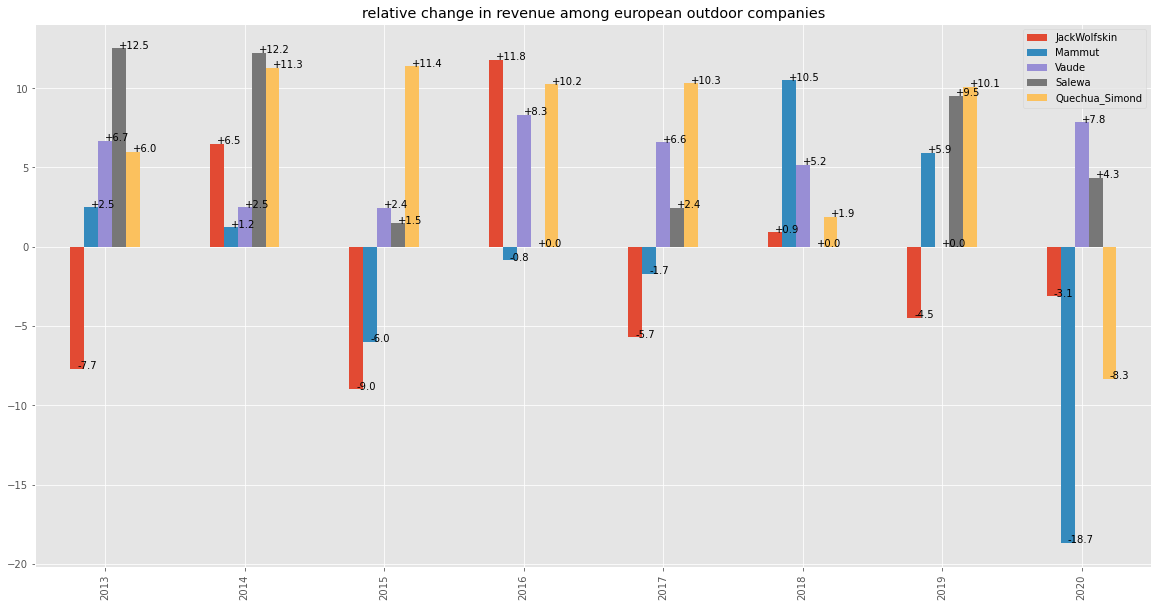

In [10]:
ax = df.iloc[:,[0,1,2,5,6]].pct_change().mul(100).round(2)
ax = ax[ax.index>2012]
ax = ax.plot(kind='bar',figsize=(20,10));
plt.title('relative change in revenue among european outdoor companies')
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.1f}".format(b.y1+b.y0)        
    ax.annotate(val,((b.x0+b.x1)/2,b.y1))

**Conclusion 1:** The market is globally dominated by the American companies The North Face and Columbia, in Europe Jack Wolfskin and Mammut are showing strong revenues. While the former dropped in sales since 2013, the later was hit hard by the pandemic. Quechua and Simond show two-digit growth rates except of last year. An interesting case is Vaude that shows very stable growth rates, including 2020. 

## 2. Scraping product prices

2.1. Scrape data for Quechua and store in DataFrame

In [11]:
headers = {"Accept":"*/*",
           "Accept-Encoding":"gzip, deflate, br",
           "Accept-Language":"en-US,en;q=0.5",
           "Cache-Control":"max-age=0",
           "Connection":"keep-alive",
           "Host":"www.decathlon.fr",
           "Sec-Fetch-Dest":"script",
           "Sec-Fetch-Mode":"no-cors",
           "Sec-Fetch-Site":"same-origin",
           "TE":"trailers",
           "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0"}

In [12]:
url_origine = "https://www.decathlon.fr/browse/b/quechua/c0-tous-les-sports/c1-randonnee-trek/c2-vetements/_/N-1ykqjryZ1egn7r3"

quechua_products = []
quechua_prices = []

for i in range(0,8):
    if i == 0:
        url_complete = url_origine
    else:
        url_complete = url_origine+"?from="+str(i*40)+"&size=40"
        
    quechua = requests.Session().get(url_complete,headers=headers)
    soup = BeautifulSoup(quechua.content)
        
    for h in soup.find_all(class_='dpb-holder loaded svelte-113iq8r'):
        for c in h.find_all(class_='dpb-informations svelte-113iq8r'):
            for p in c.find_all(class_='dpb-product-link svelte-113iq8r'):
                for s in p.find_all('span'):
                    quechua_products.append(s.text)
    for h in soup.find_all(class_='dpb-holder loaded svelte-113iq8r'):
        for c in h.find_all(class_='prc__cartridge'):
            for p in c.find_all(class_='prc__active-price'):
                quechua_prices.append(p.text)
                    
quechua_prices = [x.replace('\n', '') for x in quechua_prices]
print(len(quechua_products))
print(len(quechua_prices))

291
291


In [13]:
quechua_scraped = pd.DataFrame({'product':quechua_products,'price':quechua_prices})

In [14]:
def gender(product):
    if search('Femme',product,re.IGNORECASE):
        return 'women'
    elif search('Homme',product,re.IGNORECASE):
        return 'men'
    elif search('enfant',product,re.IGNORECASE):
        return 'children'
    else:
        return 'unisex'

In [15]:
def category(product):
    if search('Veste',product,re.IGNORECASE):
        return 'jacket'
    elif search('Pantalon',product,re.IGNORECASE):
        return 'pants'
    elif search('Chaussettes',product,re.IGNORECASE):
        return 'socks'
    elif search('Gilet',product,re.IGNORECASE):
        return 'vest'
    elif search('Gants',product,re.IGNORECASE):
        return 'gloves'
    elif search('Polaire',product,re.IGNORECASE):
        return 'fleece'
    elif search('Doudoune',product,re.IGNORECASE):
        return 'coat'
    elif search('Legging',product,re.IGNORECASE):
        return 'legging'
    elif search('T-Shirt',product,re.IGNORECASE):
        return 't-shirt'
    else:
        return 'unknown'

In [16]:
quechua_scraped['gender'] = quechua_scraped['product'].apply(gender)

In [17]:
quechua_scraped['category'] = quechua_scraped['product'].apply(category)

In [18]:
quechua_scraped.head(3)

,product,price,gender,category
0,Chaussettes chaudes de randonnée - SH500 U-WAR...,14€,unisex,socks
1,PANTALON CHAUD DÉPERLANT DE RANDONNÉE NEIGE - ...,50€,men,pants
2,Pantalon chaud déperlant de randonnée - SH100 ...,20€,women,pants


In [19]:
quechua_scraped['brand'] = 'quechua'

In [20]:
quechua_scraped.drop(['product'],axis=1,inplace=True)

In [21]:
quechua_scraped.gender.value_counts()

children    113
men          81
women        80
unisex       17
Name: gender, dtype: int64

In [22]:
quechua_scraped.category.value_counts()

jacket     83
unknown    70
pants      58
t-shirt    29
fleece     15
vest       11
coat        8
legging     6
socks       6
gloves      5
Name: category, dtype: int64

2.2. Scrape data for Vaude and store in DataFrame

In [24]:
url_origine = 'https://www.vaude.com/fr-FR/search?sSearch=randonnes&p={}'

vaude_products = []

for i in range(1,9):  
    url_complete = url_origine.format(i)
        
    vaude = requests.Session().get(url_complete)
    soup = BeautifulSoup(vaude.content)
    
    for y in soup.find_all(class_='product--details'):
        vaude_products.append(y.text)
        
vaude_products = [x.replace('\n', '') for x in vaude_products]                    
print(len(vaude_products))

384


In [25]:
vaude_scraped = pd.DataFrame({'rawdata':vaude_products})

In [26]:
vaude_scraped['price'] = vaude_scraped.rawdata.apply(lambda x:re.findall('\d+,\d\d\ €',x)[0])

In [27]:
vaude_scraped['gender'] = vaude_scraped['rawdata'].apply(gender)

In [28]:
vaude_scraped['category'] = vaude_scraped['rawdata'].apply(category)

In [29]:
vaude_scraped[vaude_scraped.category!='unknown'].head(3)

,rawdata,price,gender,category
5,"Monviso veste de randonnée isolante homme200,00 €","200,00 €",men,jacket
6,"Monviso veste de randonnée isolante femme200,00 €","200,00 €",women,jacket
7,TH Wool Socks chaussettes de randonnée longues...,"17,00 €",unisex,socks


In [30]:
vaude_scraped['brand'] = 'vaude'

In [31]:
vaude_scraped.drop(['rawdata'],axis=1,inplace=True)

In [32]:
vaude_scraped['gender'].value_counts()

unisex      174
women       109
men          79
children     22
Name: gender, dtype: int64

In [33]:
vaude_scraped['category'].value_counts()

unknown    230
jacket      74
pants       44
t-shirt     17
vest         6
gloves       6
fleece       4
socks        2
coat         1
Name: category, dtype: int64

2.3. Concatenate and clean data

In [34]:
quechua_vaude = pd.concat([quechua_scraped,vaude_scraped])

In [35]:
quechua_vaude = quechua_vaude[['brand','gender','category','price']]

In [36]:
quechua_vaude['price']=quechua_vaude.price.apply(lambda x: x.replace('€',''))
quechua_vaude['price']=quechua_vaude.price.apply(lambda x: x.split(',')[0])

In [37]:
quechua_vaude['price']=quechua_vaude['price'].astype('int')

In [38]:
quechua_vaude.drop(quechua_vaude[quechua_vaude.category=='unknown'].index,inplace=True)
quechua_vaude.reset_index(drop=True,inplace=True)

In [39]:
quechua_vaude.head(3)

,brand,gender,category,price
0,quechua,men,jacket,35
1,quechua,men,pants,35
2,quechua,men,jacket,15


In [40]:
quechua_vaude.brand.value_counts()

vaude      127
quechua    110
Name: brand, dtype: int64

2.4. Compare product prices with boxplots

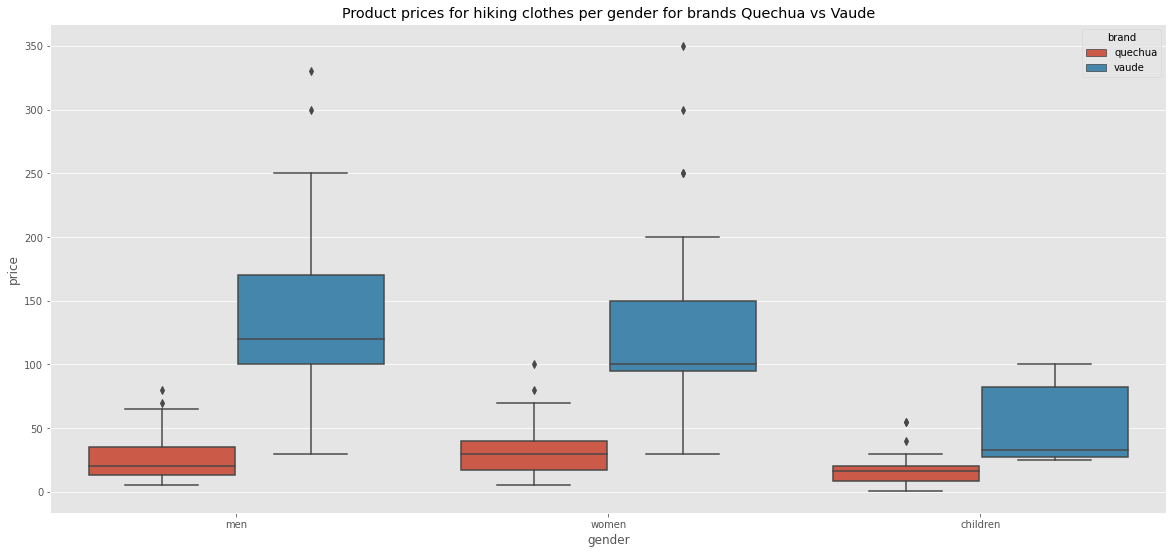

In [41]:
gender_data = quechua_vaude[quechua_vaude.gender!='unisex']

plt.figure(figsize=(20,9))
sns.boxplot(x='gender',y='price',hue='brand',data=gender_data)
plt.title('Product prices for hiking clothes per gender for brands Quechua vs Vaude')
plt.show()

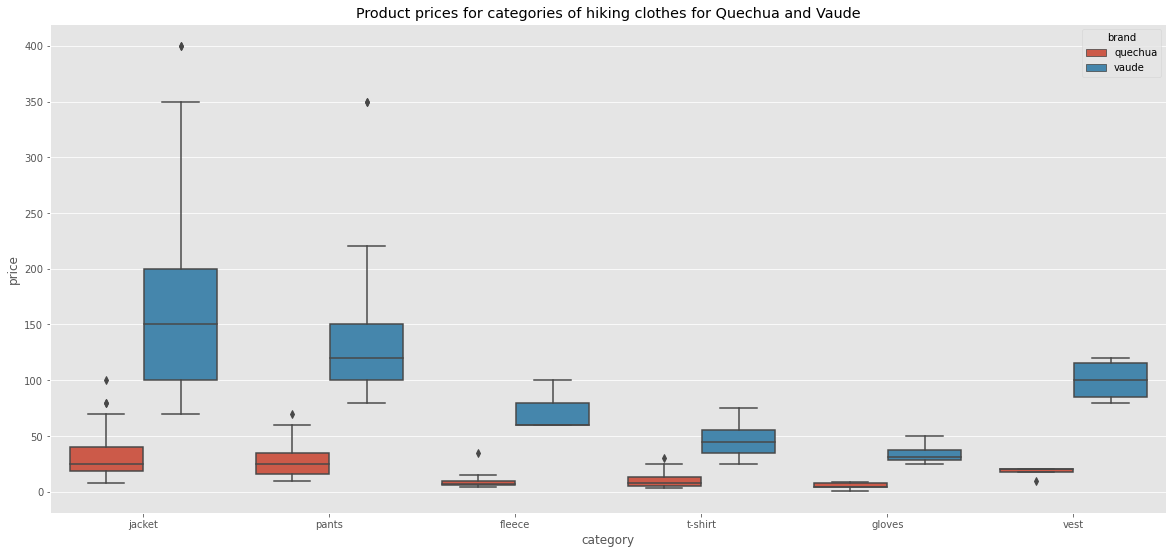

In [42]:
category_data = quechua_vaude[~quechua_vaude.category.isin(['socks','coat','legging'])]

plt.figure(figsize=(20,9))
sns.boxplot(x='category',y='price',hue='brand',data=category_data)
plt.title('Product prices for categories of hiking clothes for Quechua and Vaude')
plt.show()

**Conclusion 2:** Not surprisingly, the comparison of product prices between Quechua and Vaude shows, that the french company is consistently cheaper over all product categories and independant of gender. Regarding the position of the median in the boxplot (mostly lower end of the blue box), it can be derived that Vaude has multiple categories with pricing outliers. That means that while Vaude is already more expensive, its sortiment has some products with very hefty prices (400€). An interesting detail for Quechua is that the median is closer to the lower end of the red box for men and the upper end for women. Consequently, Quechua offers a large quantity of very low-price products for men, while for women most products are a higher intermediary price, with some outliers (100€).